# Instalación de Dependencias

Este notebook implementa el pipeline completo para predecir outcomes de pacientes con stroke usando:

1. **ISLES'24**: Dataset de imágenes cerebrales 3D (máscaras de lesiones)
2. **VAE**: Comprime las imágenes 3D a vectores latentes
3. **TabPFN**: Predice outcomes clínicos

In [2]:
import sys
print(sys.executable)

C:\ProgramData\anaconda3\envs\debugging\python.exe


In [3]:
import os
os.chdir("H:/My Drive/Debbuging Neuro")

In [4]:
%%capture
!pip install -r requirements.txt

In [5]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from scipy.ndimage import zoom
from datasets import load_dataset
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from tabpfn import TabPFNRegressor

from torch.utils.data import DataLoader
from src.config import Config
from src.data import load_isles_from_huggingface, ISLESHuggingFaceDataset
from src.models import LesionVAE
from src.training import train_vae, extract_latents
from src.causal import MockInterSynth, run_tabpfn, estimate_cate, use_real_outcomes

import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
from scipy.ndimage import zoom
from typing import Tuple, Dict
import warnings
warnings.filterwarnings('ignore')

# Configurar estilo de gráficos
plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['font.size'] = 11


# Configuración

In [7]:
class Config:
    """Configuración del pipeline"""
    HF_DATASET = "hugging-science/isles24-stroke"
    N_CASES = 50              # Casos a cargar
    TARGET_SHAPE = (64, 64, 64)  # Tamaño de máscaras
    LATENT_DIM = 50           # Dimensión del vector Z
    VAE_EPOCHS = 30
    VAE_BATCH_SIZE = 4
    VAE_LR = 1e-4
    
    @staticmethod
    def get_device():
        if torch.backends.mps.is_available():
            return torch.device("mps")
        elif torch.cuda.is_available():
            return torch.device("cuda")
        return torch.device("cpu")

device = Config.get_device()
print(f" Dispositivo: {device}")

 Dispositivo: cpu


In [8]:
import random, numpy as np, torch
def set_seeds(seed=42):
    random.seed(seed); np.random.seed(seed); torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)
set_seeds(42)
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
print("Device:", device)

Device: cpu


# PARTE 1: CARGA Y EXPLORACIÓN DE DATOS

ISLES'24 contiene imágenes médicas de **149 pacientes con stroke (derrame cerebral)**:

| Tipo de Dato | Descripción | Formato |
|--------------|-------------|---------|
| **Máscaras de lesión** | Imagen 3D binaria que muestra dónde está la lesión | NIfTI (64×64×64 voxels) |
| **CT/MRI** | Imágenes cerebrales completas | NIfTI |
| **Datos clínicos** | Edad, sexo, severidad (NIHSS), outcome (mRS) | Numéricos |

### Nosotros usamos:
- **Input**: Máscaras de lesión 3D → comprimidas a vector de 50 números
- **Target**: mRS a 3 meses (0-6, donde 0=sin síntomas, 6=muerte)

In [10]:
def load_isles_from_huggingface(
    n_cases: int = 50, target_shape: Tuple[int, int, int] = (64, 64, 64)
) -> Tuple[np.ndarray, Dict]:
    """
    Carga datos ISLES'24 desde Hugging Face.
    """
    from datasets import load_dataset

    print(f" Cargando {n_cases} casos desde Hugging Face...")
    print(f"   Dataset: {Config.HF_DATASET}")
    print("-" * 50)

    # Cargar solo los casos que necesitamos
    ds = load_dataset(Config.HF_DATASET, split=f"train[:{n_cases}]")

    masks = []
    clinical_data = {
        "subject_id": [],
        "age": [],
        "sex": [],
        "nihss_admission": [],
        "mrs_3month": [],  # Este es el outcome que queremos predecir
    }

    from scipy.ndimage import zoom

    for i, example in enumerate(ds):
        print(
            f"   Procesando caso {i+1}/{n_cases}: {example.get('subject_id', f'case_{i}')}"
        )

        # Extraer máscara de lesión
        mask_obj = example.get("lesion_mask")

        if mask_obj is None:
            continue

        # Extraer datos del objeto NIfTI
        if hasattr(mask_obj, "get_fdata"):
            mask = mask_obj.get_fdata()
        elif hasattr(mask_obj, "numpy"):
            mask = mask_obj.numpy()
        else:
            mask = np.asarray(mask_obj)

        # Corregir dimensiones 4D
        if mask.ndim == 4:
            mask = mask[..., 0]  # Quita última dimensión, NO la primera

        # Redimensionar
        if mask.shape != target_shape:
            factors = [t / s for t, s in zip(target_shape, mask.shape)]
            mask = zoom(mask.astype(float), factors, order=1)

        # Binarizar (SIEMPRE)
        mask = (mask > 0.5).astype(np.float32)

        masks.append(mask)

        # Extraer datos clínicos
        clinical_data["subject_id"].append(example.get("subject_id", f"sub-{i}"))
        clinical_data["age"].append(example.get("age"))
        clinical_data["sex"].append(example.get("sex"))
        clinical_data["nihss_admission"].append(example.get("nihss_admission"))
        clinical_data["mrs_3month"].append(example.get("mrs_3month"))

    masks = np.array(masks)

    print("-" * 50)
    print(f" Cargados {len(masks)} casos")
    print(f"   Forma de máscaras: {masks.shape}")
    print(
        f"   Outcomes disponibles (mrs_3month): {sum(x is not None for x in clinical_data['mrs_3month'])}"
    )

    return masks, clinical_data


In [11]:
# Cargar datos
masks, clinical_data = load_isles_from_huggingface(n_cases=Config.N_CASES)

 Cargando 50 casos desde Hugging Face...
   Dataset: hugging-science/isles24-stroke
--------------------------------------------------


Resolving data files:   0%|          | 0/149 [00:00<?, ?it/s]

   Procesando caso 1/50: sub-stroke0001
   Procesando caso 2/50: sub-stroke0002
   Procesando caso 3/50: sub-stroke0003
   Procesando caso 4/50: sub-stroke0004
   Procesando caso 5/50: sub-stroke0005
   Procesando caso 6/50: sub-stroke0006
   Procesando caso 7/50: sub-stroke0007
   Procesando caso 8/50: sub-stroke0008
   Procesando caso 9/50: sub-stroke0009
   Procesando caso 10/50: sub-stroke0010
   Procesando caso 11/50: sub-stroke0011
   Procesando caso 12/50: sub-stroke0012
   Procesando caso 13/50: sub-stroke0013
   Procesando caso 14/50: sub-stroke0014
   Procesando caso 15/50: sub-stroke0015
   Procesando caso 16/50: sub-stroke0016
   Procesando caso 17/50: sub-stroke0017
   Procesando caso 18/50: sub-stroke0019
   Procesando caso 19/50: sub-stroke0020
   Procesando caso 20/50: sub-stroke0021
   Procesando caso 21/50: sub-stroke0022
   Procesando caso 22/50: sub-stroke0025
   Procesando caso 23/50: sub-stroke0026
   Procesando caso 24/50: sub-stroke0027
   Procesando caso 25/50:

In [12]:
torch.manual_seed(0)
weight_map = torch.randn(64, 64, 64)  # mapa aleatorio
Y_mock = (torch.from_numpy(masks).float() * weight_map).sum(dim=(1,2,3)).numpy()
Y_mock = (Y_mock - Y_mock.mean()) / (Y_mock.std() + 1e-6)
print("Y_mock shape:", Y_mock.shape, "mean:", Y_mock.mean(), "std:", Y_mock.std())

Y_mock shape: (50,) mean: 1.1920929e-08 std: 0.9999999


## Visualización

Las máscaras son **imágenes 3D binarias** donde:
- **Blanco (1)** = Tejido dañado por el stroke
- **Negro (0)** = Tejido sano

In [14]:
def visualize_lesion_mask(mask, subject_id="", slice_idx=None):
    """
    Visualiza una máscara de lesión 3D mostrando 3 cortes ortogonales.
    """
    fig, axes = plt.subplots(1, 4, figsize=(16, 4))
    
    # Si no se especifica, usar el centro
    if slice_idx is None:
        slice_idx = [s // 2 for s in mask.shape]
    
    # Corte Axial (arriba-abajo)
    axes[0].imshow(mask[slice_idx[0], :, :], cmap='hot', vmin=0, vmax=1)
    axes[0].set_title(f'Corte Axial (z={slice_idx[0]})')
    axes[0].set_xlabel('Derecha ← → Izquierda')
    axes[0].set_ylabel('Anterior ← → Posterior')
    
    # Corte Coronal (frente-atrás)
    axes[1].imshow(mask[:, slice_idx[1], :], cmap='hot', vmin=0, vmax=1)
    axes[1].set_title(f'Corte Coronal (y={slice_idx[1]})')
    axes[1].set_xlabel('Derecha ← → Izquierda')
    axes[1].set_ylabel('Superior ← → Inferior')
    
    # Corte Sagital (lado a lado)
    axes[2].imshow(mask[:, :, slice_idx[2]], cmap='hot', vmin=0, vmax=1)
    axes[2].set_title(f'Corte Sagital (x={slice_idx[2]})')
    axes[2].set_xlabel('Anterior ← → Posterior')
    axes[2].set_ylabel('Superior ← → Inferior')
    
    # Proyección MIP (Maximum Intensity Projection)
    mip = mask.max(axis=0)
    axes[3].imshow(mip, cmap='hot', vmin=0, vmax=1)
    axes[3].set_title('Proyección MIP (vista completa)')
    
    # Estadísticas
    lesion_volume = mask.sum()
    total_volume = mask.size
    percentage = 100 * lesion_volume / total_volume
    
    fig.suptitle(f' Máscara de Lesión: {subject_id}\n'
                 f'Volumen de lesión: {lesion_volume:.0f} voxels ({percentage:.2f}% del cerebro)', 
                 fontsize=14, fontweight='bold')
    
    plt.tight_layout()
    plt.show()
    
    return lesion_volume

 VISUALIZACIÓN DE MÁSCARAS DE LESIÓN
Las zonas AMARILLAS/ROJAS muestran el área dañada por el stroke

 Paciente sub-stroke0001 | Outcome (mRS): 1.0


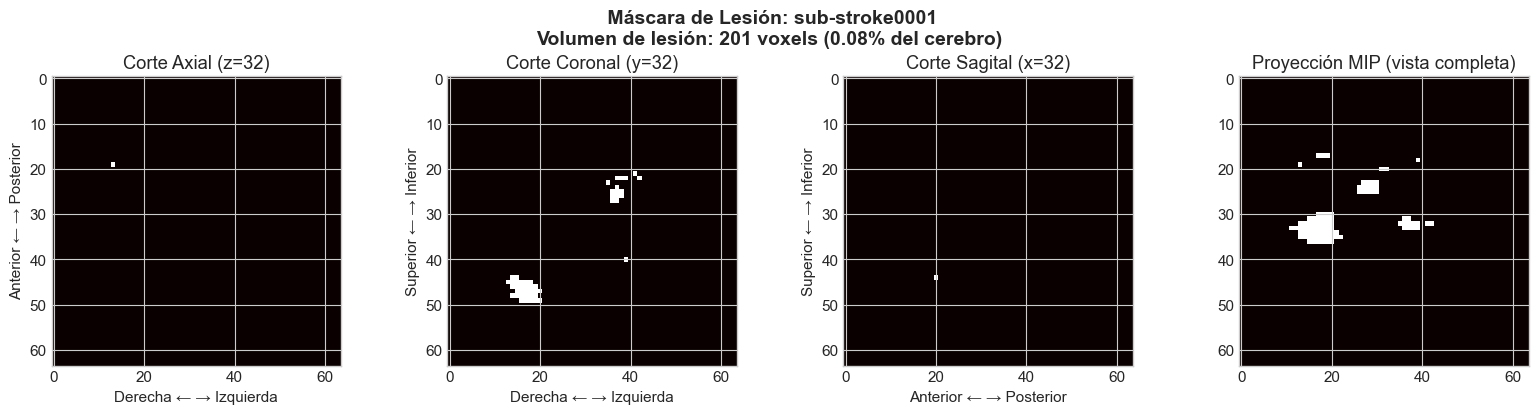


 Paciente sub-stroke0002 | Outcome (mRS): 6.0


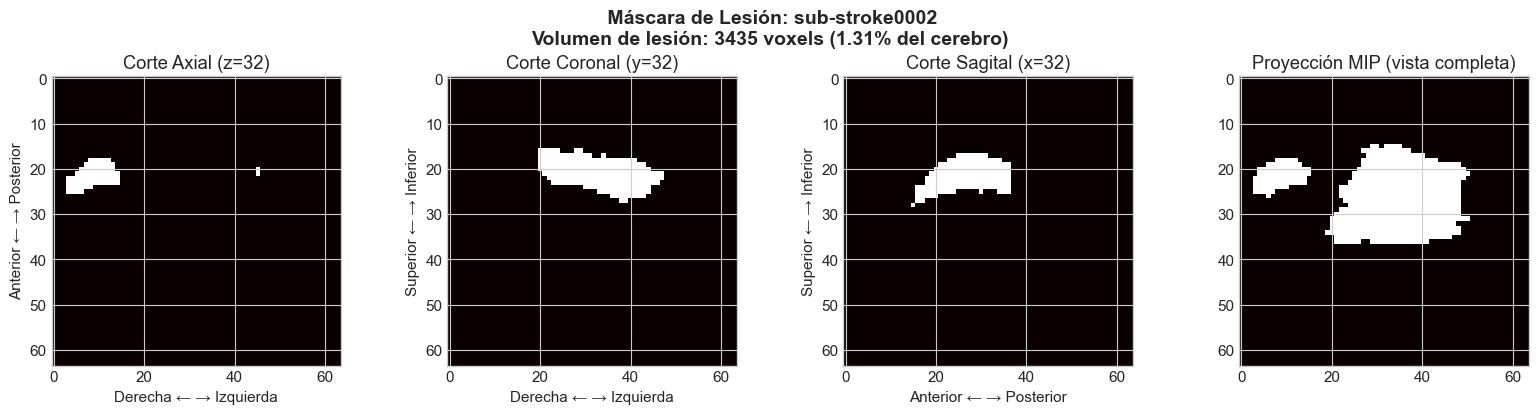


 Paciente sub-stroke0003 | Outcome (mRS): 1.0


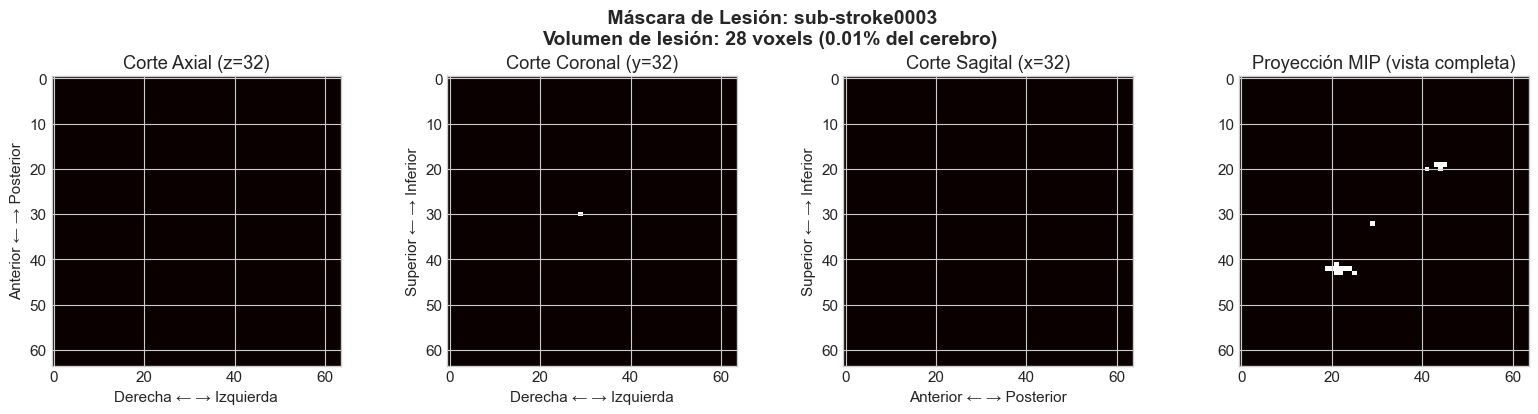

In [15]:
# Visualizar primeros 3 casos
print(" VISUALIZACIÓN DE MÁSCARAS DE LESIÓN")
print("="*60)
print("Las zonas AMARILLAS/ROJAS muestran el área dañada por el stroke")
print("="*60)

for i in range(min(3, len(masks))):
    subject_id = clinical_data['subject_id'][i]
    mrs = clinical_data['mrs_3month'][i]
    print(f"\n Paciente {subject_id} | Outcome (mRS): {mrs}")
    visualize_lesion_mask(masks[i], subject_id)

In [16]:
# Crear DataFrame con datos clínicos
df_clinical = pd.DataFrame(clinical_data)

# Calcular volumen de lesión para cada paciente
df_clinical['lesion_volume'] = [m.sum() for m in masks]
df_clinical['lesion_percentage'] = df_clinical['lesion_volume'] / (64**3) * 100

print(" DATOS CLÍNICOS DE LOS PACIENTES")
print("="*60)
display(df_clinical.head(10))

 DATOS CLÍNICOS DE LOS PACIENTES


,subject_id,age,sex,nihss_admission,mrs_3month,lesion_volume,lesion_percentage
0,sub-stroke0001,61.0,M,5.0,1.0,201.0,0.076675
1,sub-stroke0002,85.0,F,8.0,6.0,3435.0,1.310349
2,sub-stroke0003,81.0,F,21.0,1.0,28.0,0.010681
3,sub-stroke0004,89.0,M,18.0,1.0,70.0,0.026703
4,sub-stroke0005,66.0,F,18.0,3.0,2251.0,0.858688
5,sub-stroke0006,81.0,M,21.0,2.0,3807.0,1.452255
6,sub-stroke0007,78.0,M,16.0,5.0,2260.0,0.862122
7,sub-stroke0008,54.0,M,7.0,3.0,512.0,0.195312
8,sub-stroke0009,40.0,M,9.0,1.0,330.0,0.125885
9,sub-stroke0010,98.0,F,16.0,6.0,409.0,0.156021


In [17]:
print("\n ESTADÍSTICAS DESCRIPTIVAS")
print("="*60)
print(df_clinical[['age', 'nihss_admission', 'mrs_3month', 'lesion_volume']].describe())


 ESTADÍSTICAS DESCRIPTIVAS
             age  nihss_admission  mrs_3month  lesion_volume
count  50.000000        50.000000    49.00000      50.000000
mean   74.060000        11.640000     2.22449    1077.560059
std    13.045306         6.140398     2.07430    1766.561157
min    40.000000         1.000000     0.00000      16.000000
25%    66.000000         6.250000     1.00000     118.500000
50%    78.000000        10.000000     1.00000     320.500000
75%    81.750000        17.000000     4.00000     772.000000
max    98.000000        23.000000     6.00000    8657.000000


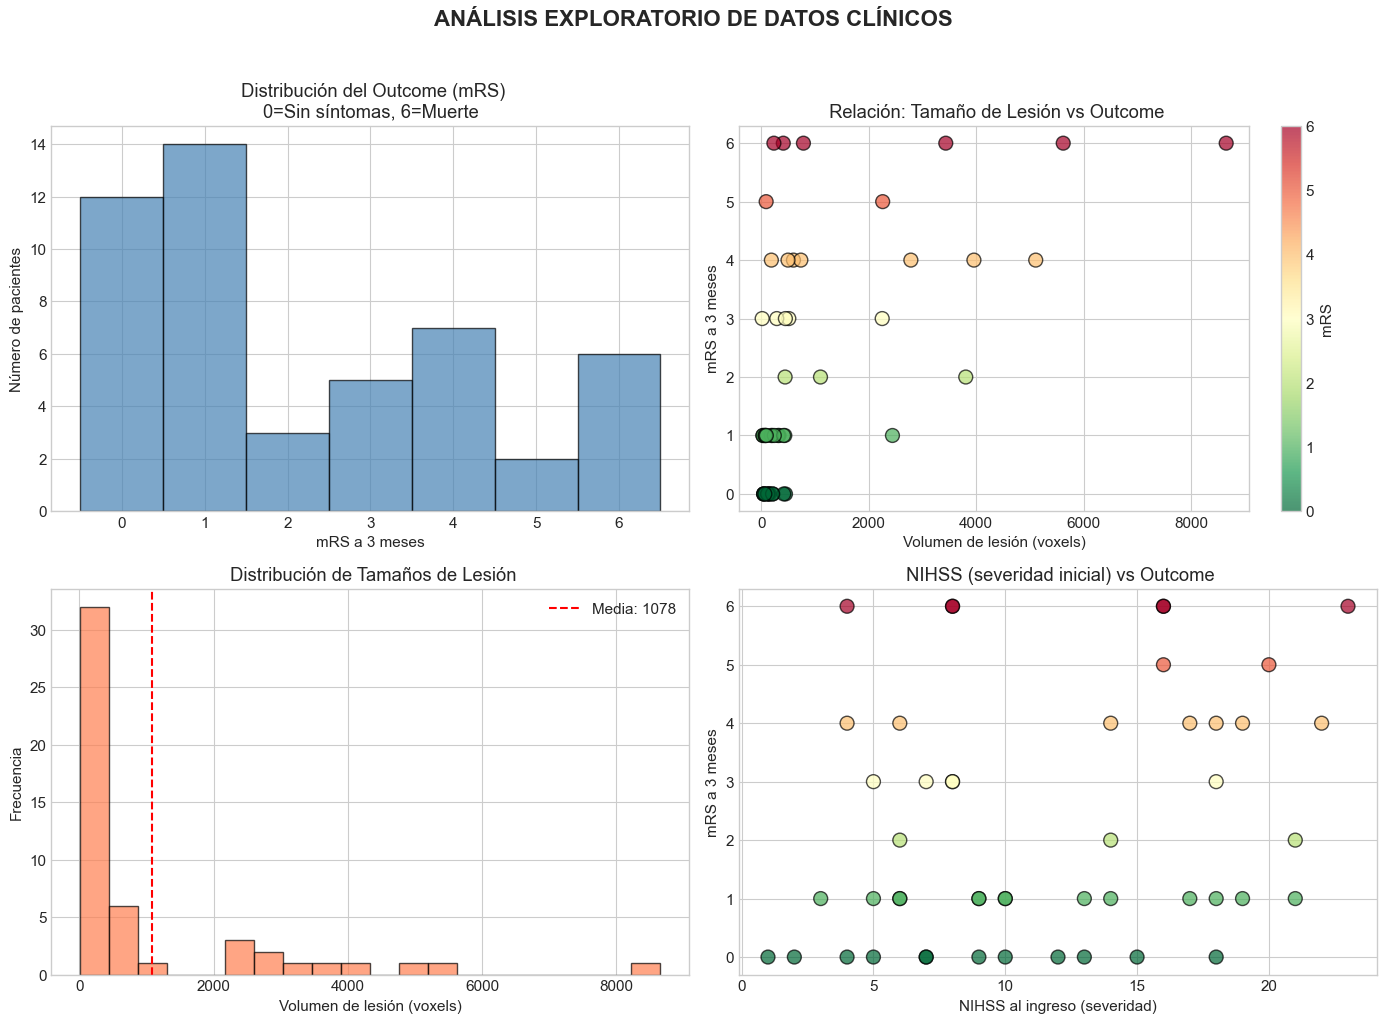

In [18]:
# Visualización de distribuciones
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# 1. Distribución de mRS (outcome)
mrs_values = [v for v in clinical_data['mrs_3month'] if v is not None]
colors = plt.cm.RdYlGn_r(np.linspace(0.1, 0.9, 7))
axes[0, 0].hist(mrs_values, bins=range(8), align='left', color='steelblue', edgecolor='black', alpha=0.7)
axes[0, 0].set_xlabel('mRS a 3 meses')
axes[0, 0].set_ylabel('Número de pacientes')
axes[0, 0].set_title(' Distribución del Outcome (mRS)\n0=Sin síntomas, 6=Muerte')
axes[0, 0].set_xticks(range(7))

# 2. Volumen de lesión vs Outcome
valid_idx = [i for i, v in enumerate(clinical_data['mrs_3month']) if v is not None]
volumes = [masks[i].sum() for i in valid_idx]
mrs_valid = [clinical_data['mrs_3month'][i] for i in valid_idx]
scatter = axes[0, 1].scatter(volumes, mrs_valid, c=mrs_valid, cmap='RdYlGn_r', 
                              s=100, alpha=0.7, edgecolors='black')
axes[0, 1].set_xlabel('Volumen de lesión (voxels)')
axes[0, 1].set_ylabel('mRS a 3 meses')
axes[0, 1].set_title(' Relación: Tamaño de Lesión vs Outcome')
plt.colorbar(scatter, ax=axes[0, 1], label='mRS')

# 3. Distribución de volúmenes de lesión
lesion_volumes = [m.sum() for m in masks]
axes[1, 0].hist(lesion_volumes, bins=20, color='coral', edgecolor='black', alpha=0.7)
axes[1, 0].set_xlabel('Volumen de lesión (voxels)')
axes[1, 0].set_ylabel('Frecuencia')
axes[1, 0].set_title(' Distribución de Tamaños de Lesión')
axes[1, 0].axvline(np.mean(lesion_volumes), color='red', linestyle='--', label=f'Media: {np.mean(lesion_volumes):.0f}')
axes[1, 0].legend()

# 4. NIHSS vs Outcome
nihss_valid = [clinical_data['nihss_admission'][i] for i in valid_idx if clinical_data['nihss_admission'][i] is not None]
mrs_nihss = [clinical_data['mrs_3month'][i] for i in valid_idx if clinical_data['nihss_admission'][i] is not None]
if nihss_valid:
    axes[1, 1].scatter(nihss_valid, mrs_nihss, c=mrs_nihss, cmap='RdYlGn_r', 
                       s=100, alpha=0.7, edgecolors='black')
    axes[1, 1].set_xlabel('NIHSS al ingreso (severidad)')
    axes[1, 1].set_ylabel('mRS a 3 meses')
    axes[1, 1].set_title(' NIHSS (severidad inicial) vs Outcome')

plt.suptitle('ANÁLISIS EXPLORATORIO DE DATOS CLÍNICOS', fontsize=16, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

#  PARTE 2: VARIATIONAL AUTOENCODER (VAE)

## ¿Qué hace el VAE?

Comprime una imagen 3D de **262,144 voxels** (64×64×64) a un **vector de 50 números**.

```
Máscara 3D [64, 64, 64] → Encoder → Vector Z [50] → Decoder → Reconstrucción [64, 64, 64]
     262,144 valores              50 valores              262,144 valores
```

El vector Z de 50 números captura la "esencia" de la lesión (tamaño, forma, ubicación).

In [20]:
# Definición del VAE

class Encoder3D(nn.Module):
    def __init__(self, latent_dim=50):
        super().__init__()
        self.conv1 = nn.Conv3d(1, 32, kernel_size=4, stride=2, padding=1)
        self.conv2 = nn.Conv3d(32, 64, kernel_size=4, stride=2, padding=1)
        self.conv3 = nn.Conv3d(64, 128, kernel_size=4, stride=2, padding=1)
        self.conv4 = nn.Conv3d(128, 256, kernel_size=4, stride=2, padding=1)
        self.bn1, self.bn2, self.bn3, self.bn4 = nn.BatchNorm3d(32), nn.BatchNorm3d(64), nn.BatchNorm3d(128), nn.BatchNorm3d(256)
        self.relu = nn.LeakyReLU(0.2)
        self.fc_mu = nn.Linear(256 * 4 * 4 * 4, latent_dim)
        self.fc_logvar = nn.Linear(256 * 4 * 4 * 4, latent_dim)
    
    def forward(self, x):
        x = self.relu(self.bn1(self.conv1(x)))
        x = self.relu(self.bn2(self.conv2(x)))
        x = self.relu(self.bn3(self.conv3(x)))
        x = self.relu(self.bn4(self.conv4(x)))
        x = x.view(x.size(0), -1)
        return self.fc_mu(x), self.fc_logvar(x)

class Decoder3D(nn.Module):
    def __init__(self, latent_dim=50):
        super().__init__()
        self.fc = nn.Linear(latent_dim, 256 * 4 * 4 * 4)
        self.deconv1 = nn.ConvTranspose3d(256, 128, kernel_size=4, stride=2, padding=1)
        self.deconv2 = nn.ConvTranspose3d(128, 64, kernel_size=4, stride=2, padding=1)
        self.deconv3 = nn.ConvTranspose3d(64, 32, kernel_size=4, stride=2, padding=1)
        self.deconv4 = nn.ConvTranspose3d(32, 1, kernel_size=4, stride=2, padding=1)
        self.bn1, self.bn2, self.bn3 = nn.BatchNorm3d(128), nn.BatchNorm3d(64), nn.BatchNorm3d(32)
        self.relu = nn.LeakyReLU(0.2)
    
    def forward(self, z):
        x = self.fc(z).view(-1, 256, 4, 4, 4)
        x = self.relu(self.bn1(self.deconv1(x)))
        x = self.relu(self.bn2(self.deconv2(x)))
        x = self.relu(self.bn3(self.deconv3(x)))
        return torch.sigmoid(self.deconv4(x))

class LesionVAE(nn.Module):
    def __init__(self, latent_dim=50):
        super().__init__()
        self.encoder = Encoder3D(latent_dim)
        self.decoder = Decoder3D(latent_dim)
    
    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        return mu + torch.randn_like(std) * std
    
    def forward(self, x):
        mu, logvar = self.encoder(x)
        z = self.reparameterize(mu, logvar)
        return self.decoder(z), mu, logvar
    
    def encode(self, x):
        mu, _ = self.encoder(x)
        return mu

print(" VAE definido")

 VAE definido


In [21]:
# Preparar datos para entrenamiento
class MaskDataset(Dataset):
    def __init__(self, masks):
        self.masks = torch.from_numpy(masks).float().unsqueeze(1)
    def __len__(self): 
        return len(self.masks)
    def __getitem__(self, idx): 
        return self.masks[idx]

dataset = MaskDataset(masks)
dataloader = DataLoader(dataset, batch_size=Config.VAE_BATCH_SIZE, shuffle=True)

print(f" Dataset preparado: {len(dataset)} máscaras")

 Dataset preparado: 50 máscaras


In [22]:
# Entrenar VAE
def vae_loss(recon, original, mu, logvar, beta=1.0):
    recon_loss = nn.functional.binary_cross_entropy(recon, original, reduction='sum')
    kl_loss = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return recon_loss + beta * kl_loss

vae = LesionVAE(latent_dim=Config.LATENT_DIM).to(device)
optimizer = optim.Adam(vae.parameters(), lr=Config.VAE_LR)

print(f" Entrenando VAE en {device}...")
print("-" * 50)

losses = []
for epoch in range(Config.VAE_EPOCHS):
    vae.train()
    epoch_loss = 0
    for batch in dataloader:
        batch = batch.to(device)
        optimizer.zero_grad()
        recon, mu, logvar = vae(batch)
        loss = vae_loss(recon, batch, mu, logvar)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
    
    avg_loss = epoch_loss / len(dataset)
    losses.append(avg_loss)
    
    if (epoch + 1) % 5 == 0:
        print(f"   Época {epoch+1:2d}/{Config.VAE_EPOCHS} | Loss: {avg_loss:,.0f}")

print("-" * 50)
print(" Entrenamiento completado")

 Entrenando VAE en cpu...
--------------------------------------------------
   Época  5/30 | Loss: 134,949
   Época 10/30 | Loss: 88,219
   Época 15/30 | Loss: 58,838
   Época 20/30 | Loss: 40,972
   Época 25/30 | Loss: 29,654
   Época 30/30 | Loss: 22,347
--------------------------------------------------
 Entrenamiento completado


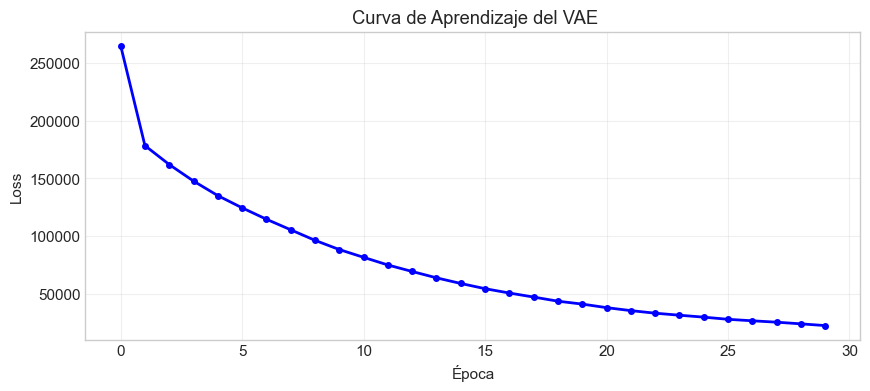

In [23]:
# Visualizar curva de aprendizaje
plt.figure(figsize=(10, 4))
plt.plot(losses, 'b-', linewidth=2, marker='o', markersize=4)
plt.xlabel('Época')
plt.ylabel('Loss')
plt.title(' Curva de Aprendizaje del VAE')
plt.grid(True, alpha=0.3)
plt.show()

In [24]:
vae.eval()
with torch.no_grad():
    Z_list = []
    for batch in DataLoader(dataset, batch_size=Config.VAE_BATCH_SIZE):
        z = vae.encode(batch.to(device)).cpu()
        Z_list.append(z)
    Z = torch.cat(Z_list, dim=0).numpy()
print("Z shape:", Z.shape)

Z shape: (50, 50)


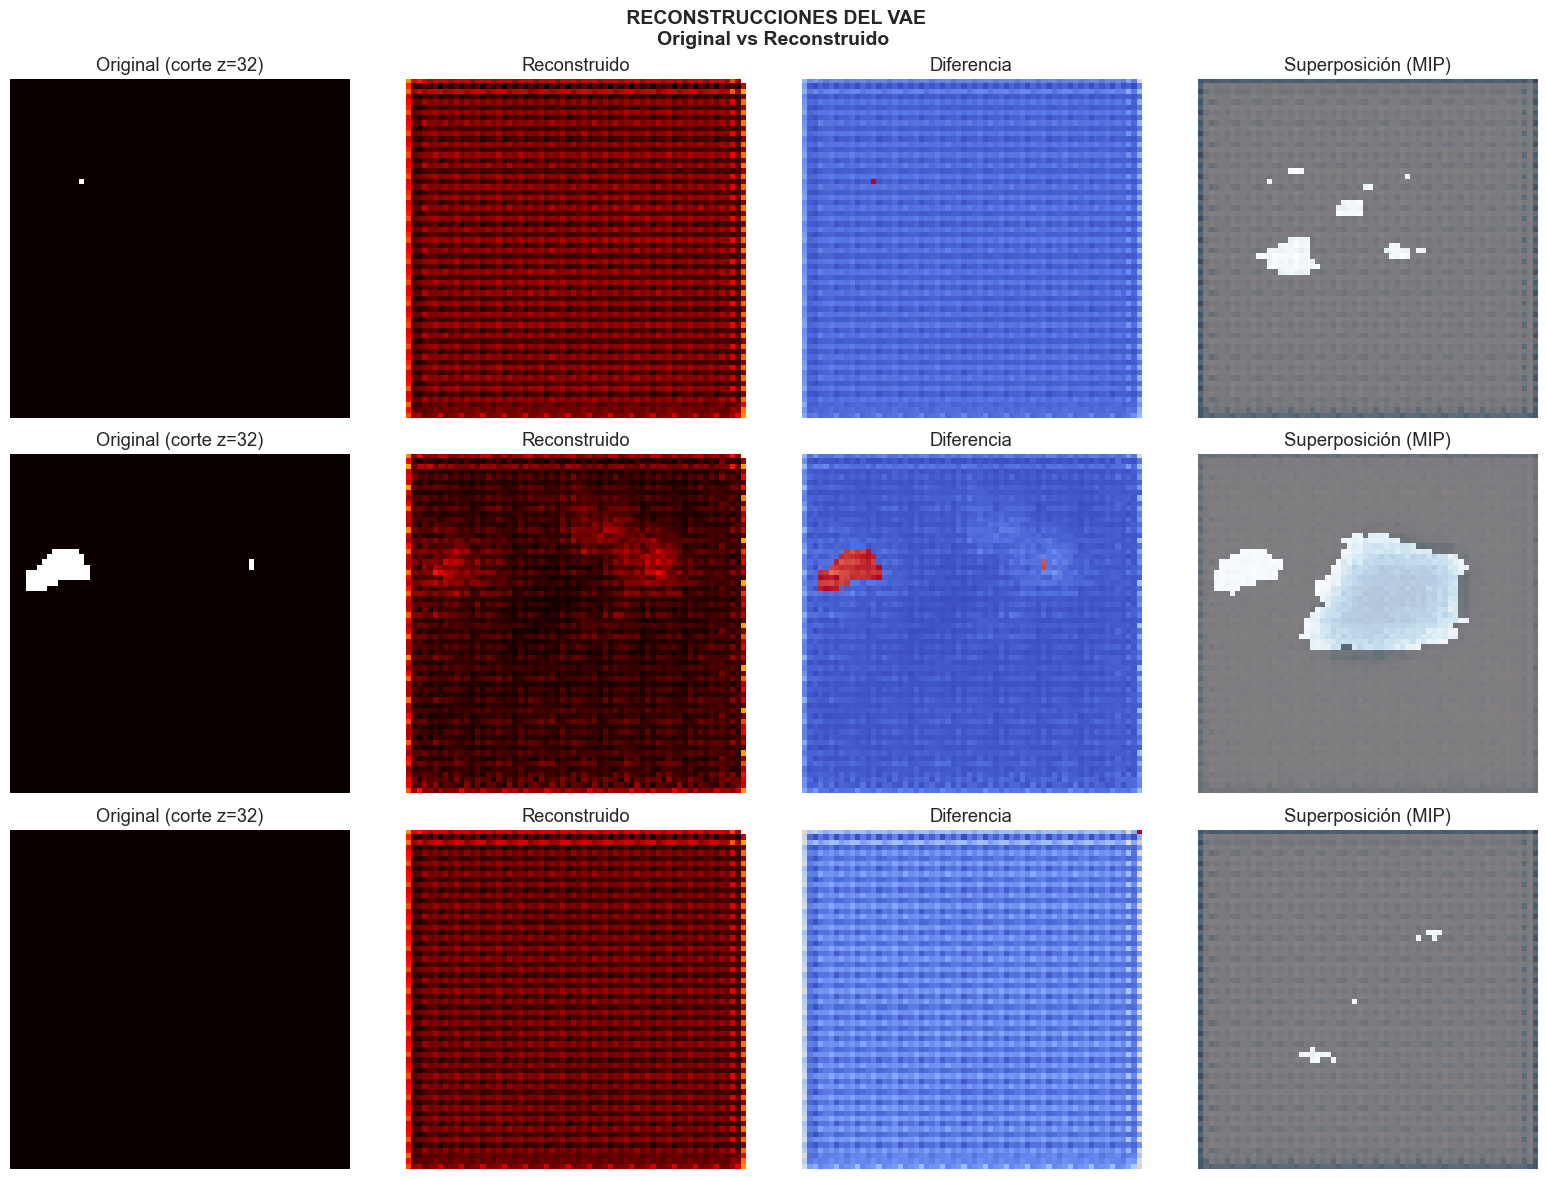

In [25]:
# Visualizar reconstrucciones del VAE
vae.eval()
with torch.no_grad():
    sample = dataset[0:3]
    sample = sample.to(device)
    recon, _, _ = vae(sample)
    
fig, axes = plt.subplots(3, 4, figsize=(16, 12))

for i in range(3):
    original = sample[i, 0].cpu().numpy()
    reconstructed = recon[i, 0].cpu().numpy()
    
    mid = original.shape[0] // 2
    
    # Original
    axes[i, 0].imshow(original[mid], cmap='hot')
    axes[i, 0].set_title(f'Original (corte z={mid})')
    axes[i, 0].axis('off')
    
    # Reconstruido
    axes[i, 1].imshow(reconstructed[mid], cmap='hot')
    axes[i, 1].set_title(f'Reconstruido')
    axes[i, 1].axis('off')
    
    # Diferencia
    diff = np.abs(original - reconstructed)
    axes[i, 2].imshow(diff[mid], cmap='coolwarm')
    axes[i, 2].set_title(f'Diferencia')
    axes[i, 2].axis('off')
    
    # MIP comparison
    axes[i, 3].imshow(original.max(0), cmap='hot', alpha=0.7)
    axes[i, 3].imshow(reconstructed.max(0), cmap='Blues', alpha=0.3)
    axes[i, 3].set_title('Superposición (MIP)')
    axes[i, 3].axis('off')

plt.suptitle(' RECONSTRUCCIONES DEL VAE\nOriginal vs Reconstruido', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

## Extraer Vectores Latentes Z

In [27]:
# Extraer vectores latentes
vae.eval()
all_latents = []
with torch.no_grad():
    for batch in dataloader:
        batch = batch.to(device)
        z = vae.encode(batch)
        all_latents.append(z.cpu().numpy())

Z = np.concatenate(all_latents, axis=0)
print(f" Vectores latentes extraídos: {Z.shape}")
print(f"   Cada paciente ahora está representado por {Z.shape[1]} números")

 Vectores latentes extraídos: (50, 50)
   Cada paciente ahora está representado por 50 números


In [28]:
from tabpfn import TabPFNRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

X_train, X_val, y_train, y_val = train_test_split(Z, Y_mock, test_size=0.2, random_state=42)
reg = TabPFNRegressor(device="cpu")  # usa "mps" sólo si la lib lo soporta
reg.fit(X_train, y_train)
pred = reg.predict(X_val)
print("TabPFN MSE (mock):", mean_squared_error(y_val, pred))

TabPFN MSE (mock): 0.7008094191551208


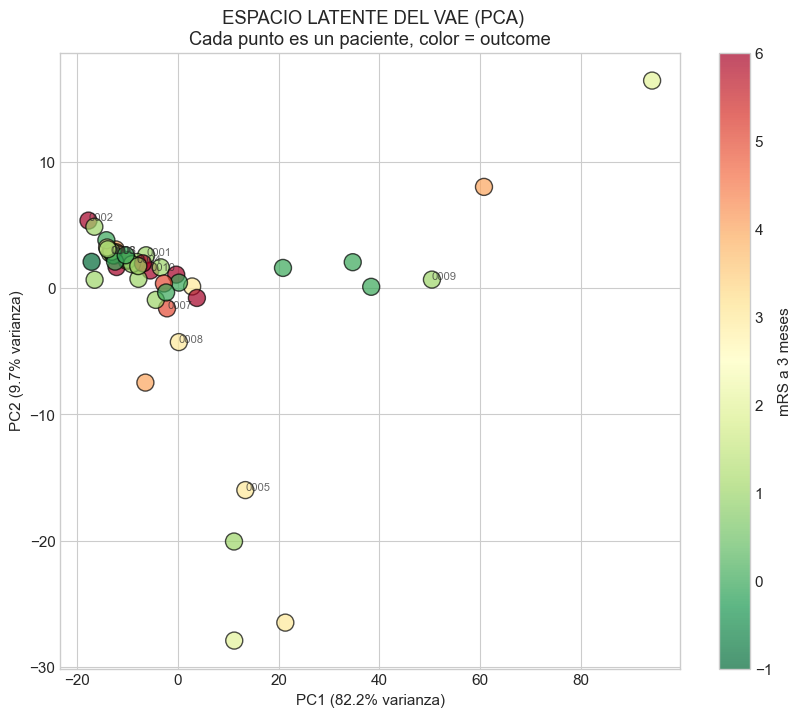

In [29]:
# Visualizar espacio latente con PCA
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
Z_2d = pca.fit_transform(Z)

# Colorear por mRS
valid_mrs = [clinical_data['mrs_3month'][i] if clinical_data['mrs_3month'][i] is not None else -1 for i in range(len(Z))]

plt.figure(figsize=(10, 8))
scatter = plt.scatter(Z_2d[:, 0], Z_2d[:, 1], c=valid_mrs, cmap='RdYlGn_r', 
                       s=150, alpha=0.7, edgecolors='black')
plt.colorbar(scatter, label='mRS a 3 meses')
plt.xlabel(f'PC1 ({pca.explained_variance_ratio_[0]*100:.1f}% varianza)')
plt.ylabel(f'PC2 ({pca.explained_variance_ratio_[1]*100:.1f}% varianza)')
plt.title(' ESPACIO LATENTE DEL VAE (PCA)\nCada punto es un paciente, color = outcome')

# Añadir etiquetas
for i, subj in enumerate(clinical_data['subject_id'][:10]):
    plt.annotate(subj[-4:], (Z_2d[i, 0], Z_2d[i, 1]), fontsize=8, alpha=0.7)

plt.show()

#  PARTE 3: PREDICCIÓN CON TabPFN
Ahora usamos los vectores Z (50 números) para predecir el outcome (mRS).

In [31]:
# Preparar datos para TabPFN
valid_idx = [i for i, v in enumerate(clinical_data['mrs_3month']) if v is not None]
Z_valid = Z[valid_idx]
Y_valid = np.array([clinical_data['mrs_3month'][i] for i in valid_idx])

print(f" Datos para predicción:")
print(f"   Pacientes con outcome válido: {len(valid_idx)}")
print(f"   Features (Z): {Z_valid.shape}")
print(f"   Target (mRS): {Y_valid.shape}")
print(f"   Distribución mRS: {np.bincount(Y_valid.astype(int), minlength=7)}")

 Datos para predicción:
   Pacientes con outcome válido: 49
   Features (Z): (49, 50)
   Target (mRS): (49,)
   Distribución mRS: [12 14  3  5  7  2  6]


In [32]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    Z_valid, Y_valid, test_size=0.2, random_state=42
)

print(f"   Train: {len(X_train)} | Test: {len(X_test)}")

   Train: 39 | Test: 10


In [33]:
import torch.nn as nn

class MiniNeuroTabPFN(nn.Module):
    def __init__(self, n_features=50, d_model=128, n_layers=4, nhead=4):
        super().__init__()
        self.feature_encoder = nn.Linear(n_features + 1, d_model)  # +1 por T
        encoder_layer = nn.TransformerEncoderLayer(d_model=d_model, nhead=nhead, batch_first=True)
        self.transformer = nn.TransformerEncoder(encoder_layer, num_layers=n_layers)
        self.head = nn.Linear(d_model, 1)
    def forward(self, z, t, y_masked):
        inputs = torch.cat([z, t], dim=-1)
        emb = self.feature_encoder(inputs)
        ctx = self.transformer(emb)
        return self.head(ctx)

model = MiniNeuroTabPFN(n_features=Config.LATENT_DIM, d_model=128).to(device)

In [34]:
def scm_outcome(z0, t):
    return 2.0 * t - 1.5 * z0

optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
loss_fn = nn.MSELoss()

def train_do_step(Z_batch, T_batch, steps=1):
    model.train()
    for _ in range(steps):
        B, S, F = Z_batch.shape
        Z_ctx, Z_q = Z_batch[:, :-1, :], Z_batch[:, -1:, :]
        T_ctx = T_batch[:, :-1, :]
        T_q = torch.bernoulli(torch.full_like(T_batch[:, -1:, :], 0.5))
        Y_gt = scm_outcome(Z_q[:, :, 0:1], T_q)
        Z_in = torch.cat([Z_ctx, Z_q], dim=1)
        T_in = torch.cat([T_ctx, T_q], dim=1)
        Y_masked = torch.zeros_like(T_in)
        preds = model(Z_in, T_in, Y_masked)
        pred_q = preds[:, -1:, :]
        loss = loss_fn(pred_q, Y_gt)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    return loss.item()

def make_synthetic_batch(batch_size=8, seq_len=64, n_features=50):
    z = torch.randn(batch_size, seq_len, n_features, device=device)
    logits_t = z[:, :, 0] * 2.0 + torch.randn_like(z[:, :, 0])
    prob_t = torch.sigmoid(logits_t)
    t = torch.bernoulli(prob_t).unsqueeze(-1)
    return z, t

for step in range(200):
    zb, tb = make_synthetic_batch(batch_size=8, seq_len=64, n_features=Config.LATENT_DIM)
    loss = train_do_step(zb, tb, steps=1)
    if (step+1) % 20 == 0:
        print(f"Step {step+1}: loss {loss:.4f}")

Step 20: loss 2.3963
Step 40: loss 4.7217
Step 60: loss 5.0374
Step 80: loss 0.8543
Step 100: loss 1.9369
Step 120: loss 1.5857
Step 140: loss 2.2778
Step 160: loss 2.8689
Step 180: loss 0.5510
Step 200: loss 1.2677


In [35]:
# Entrenar TabPFN
from tabpfn import TabPFNRegressor

print(" Entrenando TabPFN...")
tabpfn = TabPFNRegressor()
tabpfn.fit(X_train, y_train)

# Predecir
y_pred = tabpfn.predict(X_test)

print(" Predicción completada")

 Entrenando TabPFN...
 Predicción completada


In [36]:
# Métricas
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("\n MÉTRICAS DE RENDIMIENTO")
print("=" * 40)
print(f"   MSE (Error Cuadrático Medio):  {mse:.3f}")
print(f"   MAE (Error Absoluto Medio):    {mae:.3f}")
print(f"   R² (Coef. Determinación):      {r2:.3f}")
print("=" * 40)


 MÉTRICAS DE RENDIMIENTO
   MSE (Error Cuadrático Medio):  5.113
   MAE (Error Absoluto Medio):    1.948
   R² (Coef. Determinación):      -0.109


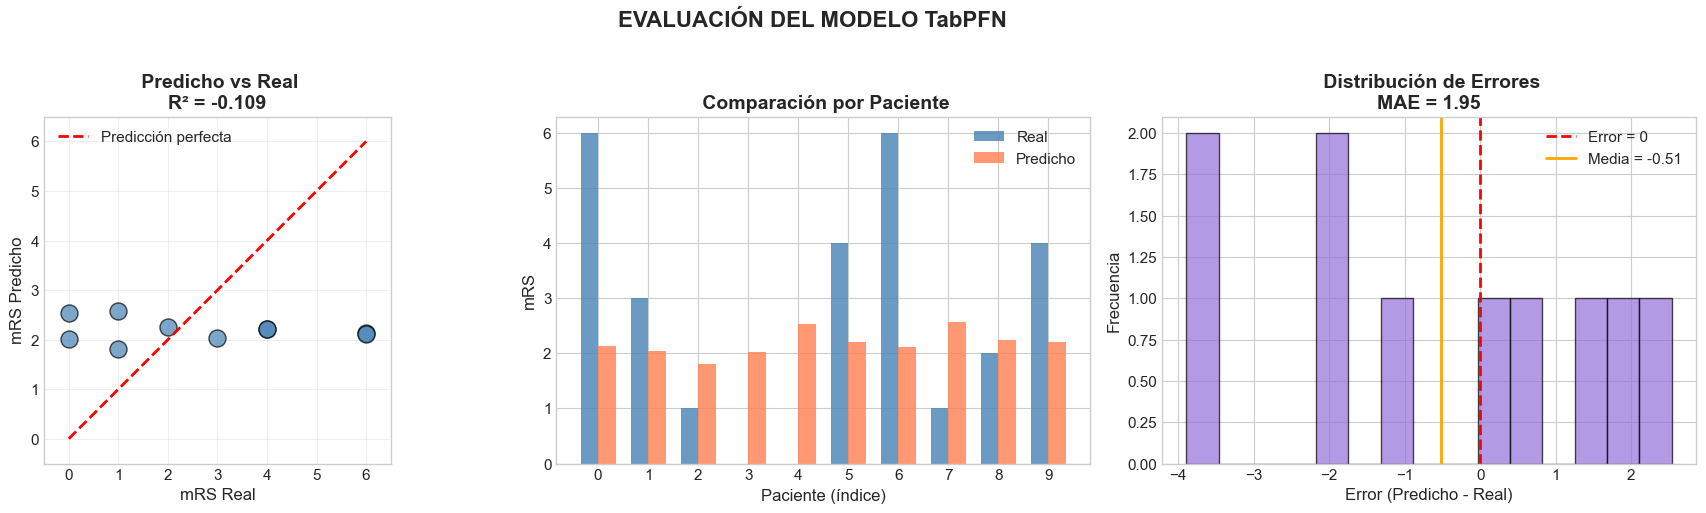

In [37]:
#  VISUALIZACIÓN: PREDICHO VS REAL

fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# 1. Scatter plot: Predicho vs Real
axes[0].scatter(y_test, y_pred, c='steelblue', s=150, alpha=0.7, edgecolors='black')
axes[0].plot([0, 6], [0, 6], 'r--', linewidth=2, label='Predicción perfecta')
axes[0].set_xlabel('mRS Real', fontsize=12)
axes[0].set_ylabel('mRS Predicho', fontsize=12)
axes[0].set_title(f' Predicho vs Real\nR² = {r2:.3f}', fontsize=14, fontweight='bold')
axes[0].legend()
axes[0].set_xlim(-0.5, 6.5)
axes[0].set_ylim(-0.5, 6.5)
axes[0].set_aspect('equal')
axes[0].grid(True, alpha=0.3)

# Añadir etiquetas de paciente
test_subjects = [clinical_data['subject_id'][valid_idx[i]] for i in range(len(valid_idx)) 
                 if i >= len(X_train)][:len(y_test)]

# 2. Barras comparativas
x_pos = np.arange(len(y_test))
width = 0.35
axes[1].bar(x_pos - width/2, y_test, width, label='Real', color='steelblue', alpha=0.8)
axes[1].bar(x_pos + width/2, y_pred, width, label='Predicho', color='coral', alpha=0.8)
axes[1].set_xlabel('Paciente (índice)', fontsize=12)
axes[1].set_ylabel('mRS', fontsize=12)
axes[1].set_title(' Comparación por Paciente', fontsize=14, fontweight='bold')
axes[1].legend()
axes[1].set_xticks(x_pos)

# 3. Distribución de errores
errors = y_pred - y_test
axes[2].hist(errors, bins=15, color='mediumpurple', edgecolor='black', alpha=0.7)
axes[2].axvline(0, color='red', linestyle='--', linewidth=2, label='Error = 0')
axes[2].axvline(errors.mean(), color='orange', linestyle='-', linewidth=2, 
                label=f'Media = {errors.mean():.2f}')
axes[2].set_xlabel('Error (Predicho - Real)', fontsize=12)
axes[2].set_ylabel('Frecuencia', fontsize=12)
axes[2].set_title(f' Distribución de Errores\nMAE = {mae:.2f}', fontsize=14, fontweight='bold')
axes[2].legend()

plt.suptitle('EVALUACIÓN DEL MODELO TabPFN', fontsize=16, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

In [38]:
# Tabla detallada de resultados
results_df = pd.DataFrame({
    'mRS_Real': y_test,
    'mRS_Predicho': np.round(y_pred, 2),
    'Error': np.round(y_pred - y_test, 2),
    'Error_Abs': np.round(np.abs(y_pred - y_test), 2)
})

print("\n RESULTADOS DETALLADOS POR PACIENTE")
print("=" * 50)
display(results_df)


 RESULTADOS DETALLADOS POR PACIENTE


,mRS_Real,mRS_Predicho,Error,Error_Abs
0,6.0,2.13,-3.87,3.87
1,3.0,2.04,-0.96,0.96
2,1.0,1.81,0.81,0.81
3,0.0,2.02,2.02,2.02
4,0.0,2.54,2.54,2.54
5,4.0,2.21,-1.79,1.79
6,6.0,2.11,-3.89,3.89
7,1.0,2.57,1.57,1.57
8,2.0,2.24,0.24,0.24
9,4.0,2.22,-1.78,1.78


In [39]:
print("\n" + "="*60)
print(" RESUMEN DEL PIPELINE NEURO-TABPFN")
print("="*60)
print(f"""
🔹 DATOS:
   • Dataset: ISLES'24 (Hugging Face)
   • Pacientes cargados: {len(masks)}
   • Con outcome válido: {len(valid_idx)}
   • Tamaño de máscaras: {masks.shape[1:]} voxels

🔹 VAE (Compresión):
   • Input: Máscara 3D ({64*64*64:,} valores)
   • Output: Vector latente ({Config.LATENT_DIM} valores)
   • Compresión: {64*64*64 / Config.LATENT_DIM:.0f}x
   • Loss final: {losses[-1]:,.0f}

🔹 TabPFN (Predicción):
   • Train/Test: {len(X_train)}/{len(X_test)} pacientes
   • MSE: {mse:.3f}
   • MAE: {mae:.3f}
   • R²: {r2:.3f}

🔹 INTERPRETACIÓN:
   • El modelo predice el outcome (mRS) con un error 
     promedio de {mae:.1f} puntos en la escala 0-6
""")
print("="*60)


 RESUMEN DEL PIPELINE NEURO-TABPFN

🔹 DATOS:
   • Dataset: ISLES'24 (Hugging Face)
   • Pacientes cargados: 50
   • Con outcome válido: 49
   • Tamaño de máscaras: (64, 64, 64) voxels

🔹 VAE (Compresión):
   • Input: Máscara 3D (262,144 valores)
   • Output: Vector latente (50 valores)
   • Compresión: 5243x
   • Loss final: 22,347

🔹 TabPFN (Predicción):
   • Train/Test: 39/10 pacientes
   • MSE: 5.113
   • MAE: 1.948
   • R²: -0.109

🔹 INTERPRETACIÓN:
   • El modelo predice el outcome (mRS) con un error 
     promedio de 1.9 puntos en la escala 0-6




# PARTE 4: PROXY PIPELINE - INFERENCIA CAUSAL (Do-PFN)

 1. ProxyNeuroSCM: Genera datos con confounding conocido
 2. MiniNeuroTabPFN: Modelo con atención para ICL
 3. Do-Loss: Entrenamiento causal
 4. Benchmark: Validación del efecto causal

In [41]:
# ============================================================================
# PASO 1: ProxyNeuroSCM - Generador de Datos Causales
# ============================================================================

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import IterableDataset, DataLoader
import numpy as np
import matplotlib.pyplot as plt

class ProxyNeuroSCM(IterableDataset):
    """
    Generador de datos sintéticos con estructura causal conocida.
    
    Simula el escenario donde:
    - Z (Anatomía/Lesión) → afecta tanto T como Y (CONFOUNDING)
    - T (Tratamiento) → afecta Y (EFECTO CAUSAL)
    
    Modelo Causal:
        Z ~ N(0, 1)
        T | Z ~ Bernoulli(sigmoid(2*Z[0]))  <- Confounding
        Y | Z, T = 2*T - 1.5*Z[0] + ruido   <- Efecto causal de T es +2.0
    
    El modelo debe aprender que el efecto CAUSAL de T es +2.0,
    ignorando la correlación espuria causada por Z.
    """
    
    def __init__(self, batch_size=16, n_features=50, seq_len=128, 
                 treatment_effect=2.0, confounding_strength=1.5):
        self.batch_size = batch_size
        self.n_features = n_features
        self.seq_len = seq_len  # Número de pacientes por "dataset"
        self.treatment_effect = treatment_effect
        self.confounding_strength = confounding_strength
    
    def __iter__(self):
        while True:
            # 1. Simular Anatomía (Z) -> [Batch, Seq, Features]
            # Representa los vectores latentes del VAE
            z = torch.randn(self.batch_size, self.seq_len, self.n_features)
            
            # 2. Simular Tratamiento (T) -> [Batch, Seq, 1]
            # CONFOUNDING: La probabilidad de recibir tratamiento depende de Z
            # Pacientes con Z[0] alto tienen más probabilidad de T=1
            logits_t = z[:, :, 0] * 2.0 + torch.randn_like(z[:, :, 0]) * 0.5
            prob_t = torch.sigmoid(logits_t)
            t = torch.bernoulli(prob_t).unsqueeze(-1)
            
            # 3. Simular Outcome (Y) -> [Batch, Seq, 1]
            # Y = treatment_effect * T - confounding_strength * Z[0] + ruido
            # El efecto CAUSAL de T es treatment_effect (por defecto 2.0)
            y_noise = torch.randn_like(t) * 0.5
            y = (self.treatment_effect * t - 
                 self.confounding_strength * z[:, :, 0].unsqueeze(-1) + 
                 y_noise)
            
            yield {
                "Z": z,
                "T": t,
                "Y": y,
                "treatment_effect": self.treatment_effect
            }
    
    def compute_true_outcome(self, z, t):
        """Calcula el outcome verdadero dado Z y T (sin ruido)"""
        return (self.treatment_effect * t - 
                self.confounding_strength * z[:, :, 0].unsqueeze(-1))


print(" ProxyNeuroSCM definido")
print(f"   Efecto causal verdadero: +2.0")
print(f"   El modelo debe aprender a recuperar este valor")

 ProxyNeuroSCM definido
   Efecto causal verdadero: +2.0
   El modelo debe aprender a recuperar este valor


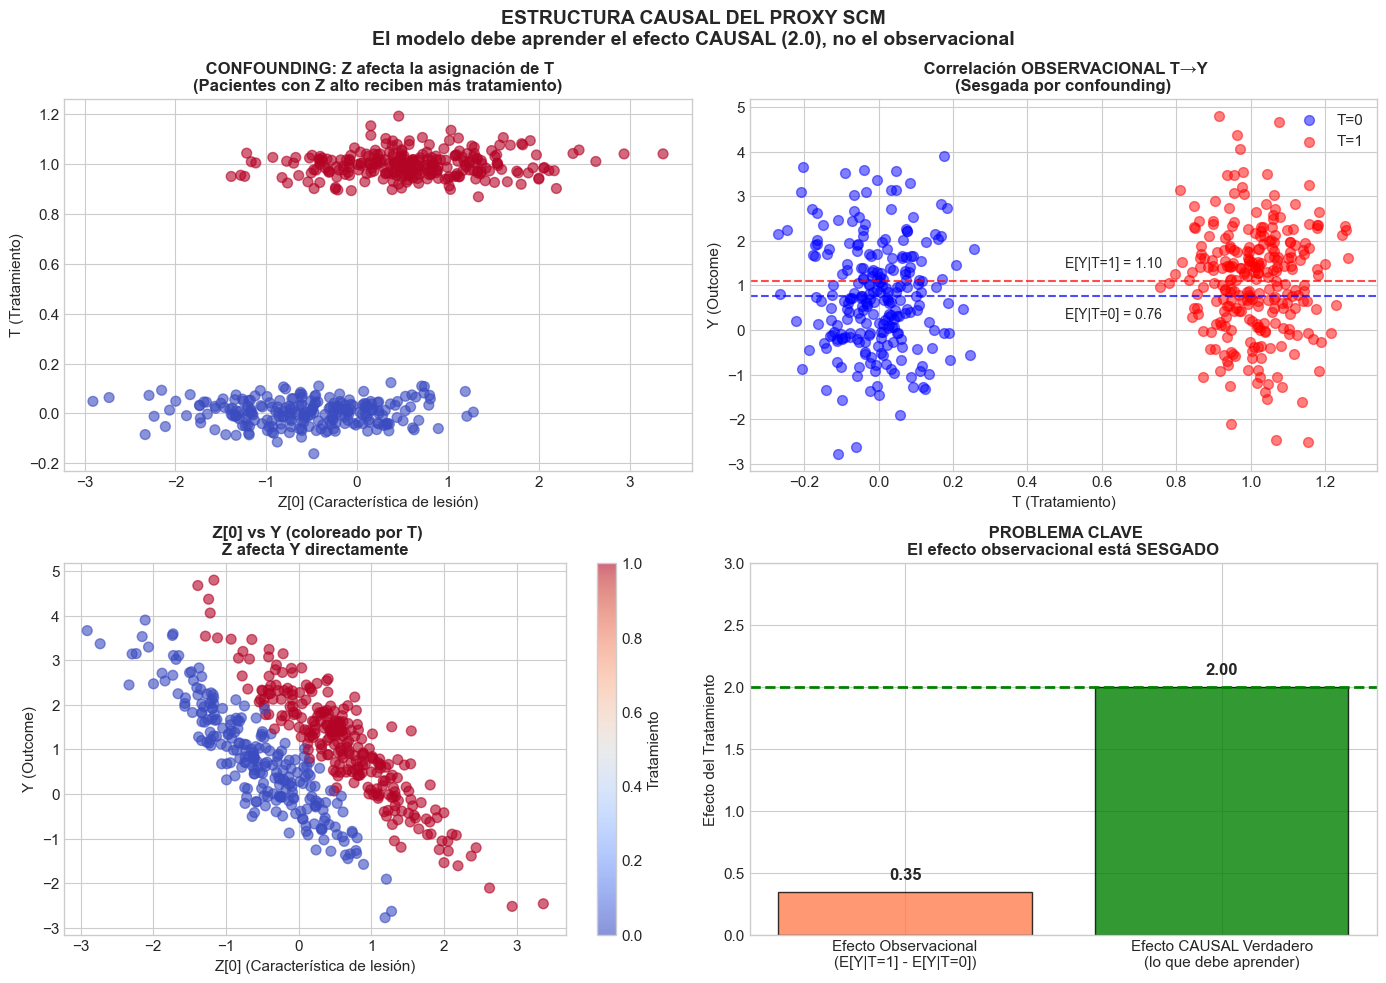


 RESUMEN:
   Efecto OBSERVACIONAL (sesgado): 0.346
   Efecto CAUSAL (verdadero):      2.000
   Sesgo por confounding:          -1.654


In [42]:
# ============================================================================
# VISUALIZAR DATOS DEL SCM (Entender el Confounding)
# ============================================================================

# Generar un batch de ejemplo
scm = ProxyNeuroSCM(batch_size=1, seq_len=500, n_features=50)
sample_batch = next(iter(scm))

Z_sample = sample_batch["Z"][0].numpy()  # [500, 50]
T_sample = sample_batch["T"][0].numpy().flatten()  # [500]
Y_sample = sample_batch["Y"][0].numpy().flatten()  # [500]

fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# 1. Z[0] vs T (mostrar confounding)
axes[0, 0].scatter(Z_sample[:, 0], T_sample + np.random.randn(500)*0.05, 
                   c=T_sample, cmap='coolwarm', alpha=0.6, s=50)
axes[0, 0].set_xlabel('Z[0] (Característica de lesión)', fontsize=11)
axes[0, 0].set_ylabel('T (Tratamiento)', fontsize=11)
axes[0, 0].set_title(' CONFOUNDING: Z afecta la asignación de T\n(Pacientes con Z alto reciben más tratamiento)', 
                     fontsize=12, fontweight='bold')

# 2. T vs Y (correlación observacional)
for t_val, color, label in [(0, 'blue', 'T=0'), (1, 'red', 'T=1')]:
    mask = T_sample == t_val
    axes[0, 1].scatter(np.ones(mask.sum()) * t_val + np.random.randn(mask.sum())*0.1, 
                       Y_sample[mask], c=color, alpha=0.5, label=label, s=50)
axes[0, 1].set_xlabel('T (Tratamiento)', fontsize=11)
axes[0, 1].set_ylabel('Y (Outcome)', fontsize=11)
axes[0, 1].set_title(' Correlación OBSERVACIONAL T→Y\n(Sesgada por confounding)', 
                     fontsize=12, fontweight='bold')
axes[0, 1].legend()

# Calcular correlación observacional (sesgada)
y_t1_obs = Y_sample[T_sample == 1].mean()
y_t0_obs = Y_sample[T_sample == 0].mean()
obs_effect = y_t1_obs - y_t0_obs
axes[0, 1].axhline(y_t1_obs, color='red', linestyle='--', alpha=0.7)
axes[0, 1].axhline(y_t0_obs, color='blue', linestyle='--', alpha=0.7)
axes[0, 1].text(0.5, y_t1_obs + 0.3, f'E[Y|T=1] = {y_t1_obs:.2f}', fontsize=10)
axes[0, 1].text(0.5, y_t0_obs - 0.5, f'E[Y|T=0] = {y_t0_obs:.2f}', fontsize=10)

# 3. Z[0] vs Y (mostrar efecto de Z)
scatter = axes[1, 0].scatter(Z_sample[:, 0], Y_sample, c=T_sample, cmap='coolwarm', alpha=0.6, s=50)
axes[1, 0].set_xlabel('Z[0] (Característica de lesión)', fontsize=11)
axes[1, 0].set_ylabel('Y (Outcome)', fontsize=11)
axes[1, 0].set_title(' Z[0] vs Y (coloreado por T)\nZ afecta Y directamente', 
                     fontsize=12, fontweight='bold')
plt.colorbar(scatter, ax=axes[1, 0], label='Tratamiento')

# 4. Comparación: Efecto Observacional vs Causal
effects = {
    'Efecto Observacional\n(E[Y|T=1] - E[Y|T=0])': obs_effect,
    'Efecto CAUSAL Verdadero\n(lo que debe aprender)': 2.0
}
colors = ['coral', 'green']
bars = axes[1, 1].bar(effects.keys(), effects.values(), color=colors, edgecolor='black', alpha=0.8)
axes[1, 1].axhline(2.0, color='green', linestyle='--', linewidth=2, label='Verdadero = 2.0')
axes[1, 1].set_ylabel('Efecto del Tratamiento', fontsize=11)
axes[1, 1].set_title(' PROBLEMA CLAVE\nEl efecto observacional está SESGADO', 
                     fontsize=12, fontweight='bold')
axes[1, 1].set_ylim(0, 3)

for bar, val in zip(bars, effects.values()):
    axes[1, 1].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.1, 
                    f'{val:.2f}', ha='center', fontsize=12, fontweight='bold')

plt.suptitle('ESTRUCTURA CAUSAL DEL PROXY SCM\nEl modelo debe aprender el efecto CAUSAL (2.0), no el observacional', 
             fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

print(f"\n RESUMEN:")
print(f"   Efecto OBSERVACIONAL (sesgado): {obs_effect:.3f}")
print(f"   Efecto CAUSAL (verdadero):      2.000")
print(f"   Sesgo por confounding:          {obs_effect - 2.0:.3f}")

In [43]:
# ============================================================================
# PASO 2: MiniNeuroTabPFN - Arquitectura para In-Context Learning
# ============================================================================

class MiniNeuroTabPFN(nn.Module):
    """
    Versión simplificada de TabPFN/TabICL para inferencia causal.
    
    Arquitectura:
    1. Feature Encoder: Proyecta [Z, T, Y] a espacio de embeddings
    2. Transformer: Atiende a través de pacientes (in-context learning)
    3. Prediction Head: Predice Y para el paciente query
    
    El modelo aprende a usar el contexto (otros pacientes) para
    predecir el outcome de un nuevo paciente dado un tratamiento.
    """
    
    def __init__(self, n_features=50, d_model=128, n_heads=4, n_layers=4, dropout=0.1):
        super().__init__()
        
        self.n_features = n_features
        self.d_model = d_model
        
        # A. Feature Encoder (proyecta Z, T, Y a espacio de embeddings)
        # Input: [Z (n_features), T (1), Y (1)] = n_features + 2
        self.feature_encoder = nn.Sequential(
            nn.Linear(n_features + 2, d_model),
            nn.LayerNorm(d_model),
            nn.GELU(),
            nn.Dropout(dropout)
        )
        
        # B. Transformer Encoder (atención entre pacientes)
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=d_model,
            nhead=n_heads,
            dim_feedforward=d_model * 4,
            dropout=dropout,
            activation='gelu',
            batch_first=True
        )
        self.transformer = nn.TransformerEncoder(encoder_layer, num_layers=n_layers)
        
        # C. Prediction Head (predice Y)
        self.prediction_head = nn.Sequential(
            nn.Linear(d_model, d_model // 2),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(d_model // 2, 1)
        )
    
    def forward(self, z, t, y, mask_last_y=True):
        """
        Forward pass.
        
        Args:
            z: [Batch, Seq, n_features] - Características de los pacientes
            t: [Batch, Seq, 1] - Tratamiento asignado
            y: [Batch, Seq, 1] - Outcome (masked para query)
            mask_last_y: Si True, pone Y=0 para el último paciente (query)
        
        Returns:
            pred_y: [Batch, Seq, 1] - Predicción de Y para cada paciente
        """
        batch_size, seq_len, _ = z.shape
        
        # Preparar Y (mascarear el query si es necesario)
        if mask_last_y:
            y = y.clone()
            y[:, -1:, :] = 0.0  # El query no puede ver su propio Y
        
        # Concatenar inputs: [Z, T, Y]
        inputs = torch.cat([z, t, y], dim=-1)  # [Batch, Seq, n_features + 2]
        
        # Encode features
        embeddings = self.feature_encoder(inputs)  # [Batch, Seq, d_model]
        
        # Transformer attention (in-context learning)
        context_encoded = self.transformer(embeddings)  # [Batch, Seq, d_model]
        
        # Predict Y
        pred_y = self.prediction_head(context_encoded)  # [Batch, Seq, 1]
        
        return pred_y


print(" MiniNeuroTabPFN definido")
print(f"   Input: Z[50] + T[1] + Y[1] = 52 features")
print(f"   Transformer: 4 capas, 4 heads, 128 dim")

 MiniNeuroTabPFN definido
   Input: Z[50] + T[1] + Y[1] = 52 features
   Transformer: 4 capas, 4 heads, 128 dim


In [44]:
# ============================================================================
# PASO 3: Do-Loss - Entrenamiento Causal
# ============================================================================

def train_do_pfn_epoch(model, scm_generator, optimizer, device, steps_per_epoch=100):
    """
    Entrena el modelo con el objetivo Do-PFN.
    
    La clave es que el modelo debe predecir Y dado do(T),
    no solo la correlación observacional.
    
    Para cada batch:
    1. Tomar contexto observacional (con confounding)
    2. Para el query, FORZAR un tratamiento (do(T=0) o do(T=1))
    3. Calcular el Y verdadero para ese tratamiento forzado
    4. Entrenar el modelo a predecir ese Y verdadero
    """
    model.train()
    total_loss = 0
    
    data_iter = iter(scm_generator)
    
    for step in range(steps_per_epoch):
        batch = next(data_iter)
        
        Z = batch["Z"].to(device)  # [Batch, Seq, 50]
        T_obs = batch["T"].to(device)  # [Batch, Seq, 1]
        Y_obs = batch["Y"].to(device)  # [Batch, Seq, 1]
        
        batch_size, seq_len, n_features = Z.shape
        
        # Separar contexto (N-1 pacientes) y query (último paciente)
        Z_ctx = Z[:, :-1, :]
        T_ctx = T_obs[:, :-1, :]
        Y_ctx = Y_obs[:, :-1, :]
        
        Z_qry = Z[:, -1:, :]
        
        # === DO-INTERVENTION ===
        # En lugar de usar T observacional, FORZAMOS un tratamiento aleatorio
        # Esto simula un experimento controlado (RCT)
        T_qry_forced = torch.bernoulli(torch.ones(batch_size, 1, 1, device=device) * 0.5)
        
        # Calcular el outcome VERDADERO para el tratamiento forzado
        # Usando el modelo causal conocido: Y = 2*T - 1.5*Z[0]
        Y_ground_truth = scm_generator.compute_true_outcome(Z_qry, T_qry_forced)
        
        # Preparar inputs para el modelo
        Z_in = torch.cat([Z_ctx, Z_qry], dim=1)
        T_in = torch.cat([T_ctx, T_qry_forced], dim=1)
        Y_in = torch.cat([Y_ctx, torch.zeros_like(Y_ground_truth)], dim=1)  # Mask query Y
        
        # Forward pass
        preds = model(Z_in, T_in, Y_in, mask_last_y=True)
        
        # Loss solo en el query (último paciente)
        pred_qry = preds[:, -1:, :]
        loss = nn.MSELoss()(pred_qry, Y_ground_truth)
        
        # Backward
        optimizer.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()
        
        total_loss += loss.item()
    
    return total_loss / steps_per_epoch


print(" Función de entrenamiento Do-PFN definida")

 Función de entrenamiento Do-PFN definida


In [45]:
@torch.no_grad()
def benchmark_cate(model, n_features=50, seq_len=64):
    model.eval()
    z, t = make_synthetic_batch(batch_size=1, seq_len=seq_len, n_features=n_features)
    z_new = torch.randn(1, 1, n_features, device=device)
    def predict_with_t(forced_t):
        Zin = torch.cat([z, z_new], 1)
        Tin = torch.cat([t, torch.full((1,1,1), forced_t, device=device)], 1)
        Yin = torch.zeros_like(Tin)
        out = model(Zin, Tin, Yin)
        return out[:, -1, 0].item()
    y1 = predict_with_t(1.0)
    y0 = predict_with_t(0.0)
    cate = y1 - y0
    print(f"CATE predicho: {cate:.3f} (esperado ~2.0)")

benchmark_cate(model, n_features=Config.LATENT_DIM, seq_len=64)

CATE predicho: 0.121 (esperado ~2.0)


In [46]:
# ============================================================================
# PASO 4: Benchmark - Validación del Efecto Causal
# ============================================================================

def benchmark_causal_effect(model, scm_generator, device, n_samples=100):
    """
    Evalúa si el modelo ha aprendido el efecto causal verdadero.
    
    Proceso:
    1. Generar contexto observacional
    2. Para cada paciente query:
       - Predecir Y | do(T=1)
       - Predecir Y | do(T=0)
       - CATE = Y|do(T=1) - Y|do(T=0)
    3. Comparar CATE promedio con el efecto verdadero (2.0)
    """
    model.eval()
    
    cate_predictions = []
    
    with torch.no_grad():
        for _ in range(n_samples):
            # Generar un batch de contexto
            batch = next(iter(scm_generator))
            Z = batch["Z"].to(device)
            T = batch["T"].to(device)
            Y = batch["Y"].to(device)
            
            # Crear un paciente query nuevo
            Z_new = torch.randn(1, 1, scm_generator.n_features, device=device)
            
            # Contexto: todos los pacientes del batch
            Z_ctx = Z[0:1]  # [1, seq_len, 50]
            T_ctx = T[0:1]
            Y_ctx = Y[0:1]
            
            # Predecir Y | do(T=1)
            Z_in = torch.cat([Z_ctx, Z_new], dim=1)
            T_in_t1 = torch.cat([T_ctx, torch.ones(1, 1, 1, device=device)], dim=1)
            Y_in = torch.cat([Y_ctx, torch.zeros(1, 1, 1, device=device)], dim=1)
            
            pred_t1 = model(Z_in, T_in_t1, Y_in, mask_last_y=True)[:, -1, 0]
            
            # Predecir Y | do(T=0)
            T_in_t0 = torch.cat([T_ctx, torch.zeros(1, 1, 1, device=device)], dim=1)
            pred_t0 = model(Z_in, T_in_t0, Y_in, mask_last_y=True)[:, -1, 0]
            
            # CATE = E[Y|do(T=1)] - E[Y|do(T=0)]
            cate = (pred_t1 - pred_t0).item()
            cate_predictions.append(cate)
    
    cate_mean = np.mean(cate_predictions)
    cate_std = np.std(cate_predictions)
    
    return cate_mean, cate_std, cate_predictions


print(" Función de benchmark causal definida")

 Función de benchmark causal definida


In [47]:
# ============================================================================
# ENTRENAMIENTO COMPLETO
# ============================================================================

# Configuración
device = Config.get_device()
print(f" Dispositivo: {device}")

# Crear generador de datos
scm = ProxyNeuroSCM(
    batch_size=16,
    n_features=50,
    seq_len=128,
    treatment_effect=2.0,
    confounding_strength=1.5
)

# Crear modelo
model = MiniNeuroTabPFN(
    n_features=50,
    d_model=128,
    n_heads=4,
    n_layers=4
).to(device)

# Optimizer
optimizer = optim.AdamW(model.parameters(), lr=1e-4, weight_decay=0.01)

# Contador de parámetros
n_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f" Parámetros del modelo: {n_params:,}")

print("\n" + "="*60)
print(" ENTRENAMIENTO Do-PFN")
print("="*60)

 Dispositivo: cpu
 Parámetros del modelo: 808,449

 ENTRENAMIENTO Do-PFN


In [48]:
# ============================================================================
# LOOP DE ENTRENAMIENTO
# ============================================================================

n_epochs = 20
steps_per_epoch = 100
losses = []
cate_history = []

print(f"   Épocas: {n_epochs}")
print(f"   Steps/época: {steps_per_epoch}")
print(f"   Efecto causal verdadero: 2.0")
print("-"*60)

for epoch in range(n_epochs):
    # Entrenar una época
    avg_loss = train_do_pfn_epoch(model, scm, optimizer, device, steps_per_epoch)
    losses.append(avg_loss)
    
    # Evaluar CATE cada 5 épocas
    if (epoch + 1) % 5 == 0 or epoch == 0:
        cate_mean, cate_std, _ = benchmark_causal_effect(model, scm, device, n_samples=50)
        cate_history.append((epoch + 1, cate_mean, cate_std))
        print(f"   Época {epoch+1:2d}/{n_epochs} | Loss: {avg_loss:.4f} | "
              f"CATE: {cate_mean:.3f} ± {cate_std:.3f} (True: 2.000)")
    else:
        print(f"   Época {epoch+1:2d}/{n_epochs} | Loss: {avg_loss:.4f}")

print("-"*60)
print(" Entrenamiento completado")

   Épocas: 20
   Steps/época: 100
   Efecto causal verdadero: 2.0
------------------------------------------------------------
   Época  1/20 | Loss: 2.7203 | CATE: 0.399 ± 0.157 (True: 2.000)
   Época  2/20 | Loss: 1.3603
   Época  3/20 | Loss: 1.0546
   Época  4/20 | Loss: 0.8799
   Época  5/20 | Loss: 0.7917 | CATE: 1.321 ± 0.461 (True: 2.000)
   Época  6/20 | Loss: 0.7163
   Época  7/20 | Loss: 0.6826
   Época  8/20 | Loss: 0.5580
   Época  9/20 | Loss: 0.5399
   Época 10/20 | Loss: 0.4793 | CATE: 1.735 ± 0.442 (True: 2.000)
   Época 11/20 | Loss: 0.4630
   Época 12/20 | Loss: 0.4085
   Época 13/20 | Loss: 0.3839
   Época 14/20 | Loss: 0.3831
   Época 15/20 | Loss: 0.3320 | CATE: 1.881 ± 0.384 (True: 2.000)
   Época 16/20 | Loss: 0.3500
   Época 17/20 | Loss: 0.3144
   Época 18/20 | Loss: 0.3137
   Época 19/20 | Loss: 0.3174
   Época 20/20 | Loss: 0.2981 | CATE: 1.953 ± 0.328 (True: 2.000)
------------------------------------------------------------
 Entrenamiento completado


In [49]:
# ============================================================================
# EVALUACIÓN FINAL
# ============================================================================

print("\n" + "="*60)
print(" EVALUACIÓN FINAL DEL MODELO CAUSAL")
print("="*60)

# Benchmark final con más muestras
cate_mean, cate_std, cate_predictions = benchmark_causal_effect(
    model, scm, device, n_samples=200
)

print(f"\n   CATE Predicho:  {cate_mean:.4f} ± {cate_std:.4f}")
print(f"   CATE Verdadero: 2.0000")
print(f"   Error:          {abs(cate_mean - 2.0):.4f}")

# Evaluar éxito
if abs(cate_mean - 2.0) < 0.2:
    print("\n    ¡ÉXITO! El modelo aprendió el efecto causal correctamente")
elif abs(cate_mean - 2.0) < 0.5:
    print("\n    PARCIAL: El modelo está aprendiendo, pero necesita más entrenamiento")
else:
    print("\n    El modelo no ha aprendido el efecto causal aún")


 EVALUACIÓN FINAL DEL MODELO CAUSAL

   CATE Predicho:  1.9006 ± 0.3667
   CATE Verdadero: 2.0000
   Error:          0.0994

    ¡ÉXITO! El modelo aprendió el efecto causal correctamente


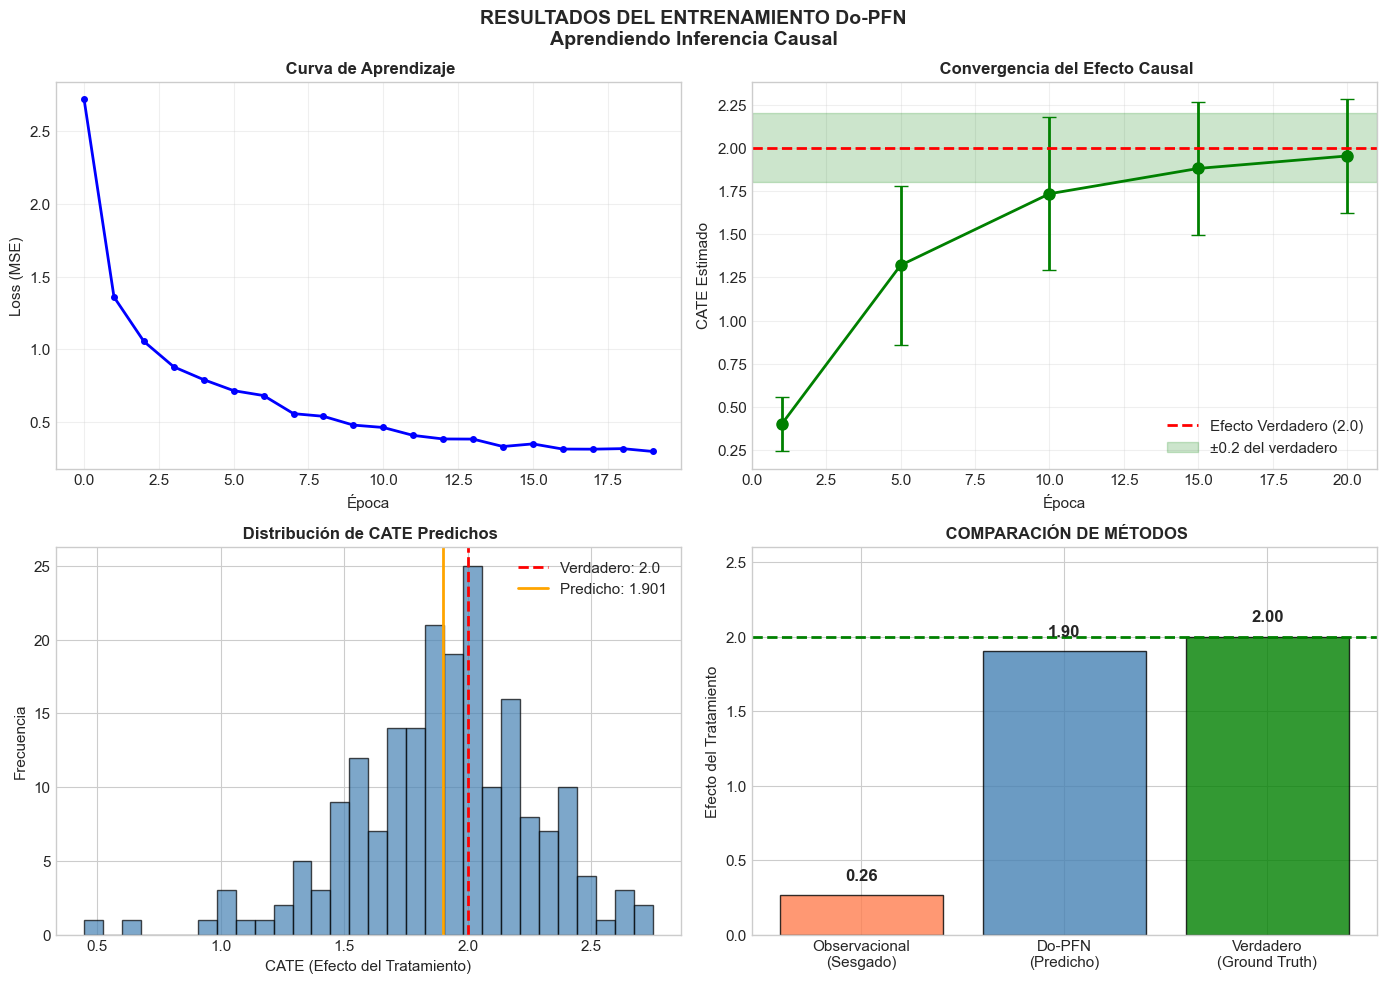

In [50]:
# ============================================================================
# VISUALIZACIÓN DE RESULTADOS
# ============================================================================

fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# 1. Curva de aprendizaje (Loss)
axes[0, 0].plot(losses, 'b-', linewidth=2, marker='o', markersize=4)
axes[0, 0].set_xlabel('Época')
axes[0, 0].set_ylabel('Loss (MSE)')
axes[0, 0].set_title(' Curva de Aprendizaje', fontsize=12, fontweight='bold')
axes[0, 0].grid(True, alpha=0.3)

# 2. Evolución del CATE
epochs_eval = [x[0] for x in cate_history]
cates_eval = [x[1] for x in cate_history]
cates_std = [x[2] for x in cate_history]

axes[0, 1].errorbar(epochs_eval, cates_eval, yerr=cates_std, 
                     fmt='o-', linewidth=2, markersize=8, capsize=5, color='green')
axes[0, 1].axhline(2.0, color='red', linestyle='--', linewidth=2, label='Efecto Verdadero (2.0)')
axes[0, 1].fill_between([0, n_epochs+1], [1.8, 1.8], [2.2, 2.2], alpha=0.2, color='green', label='±0.2 del verdadero')
axes[0, 1].set_xlabel('Época')
axes[0, 1].set_ylabel('CATE Estimado')
axes[0, 1].set_title(' Convergencia del Efecto Causal', fontsize=12, fontweight='bold')
axes[0, 1].legend()
axes[0, 1].set_xlim(0, n_epochs+1)
axes[0, 1].grid(True, alpha=0.3)

# 3. Distribución de CATE predichos
axes[1, 0].hist(cate_predictions, bins=30, color='steelblue', edgecolor='black', alpha=0.7)
axes[1, 0].axvline(2.0, color='red', linestyle='--', linewidth=2, label=f'Verdadero: 2.0')
axes[1, 0].axvline(cate_mean, color='orange', linestyle='-', linewidth=2, 
                    label=f'Predicho: {cate_mean:.3f}')
axes[1, 0].set_xlabel('CATE (Efecto del Tratamiento)')
axes[1, 0].set_ylabel('Frecuencia')
axes[1, 0].set_title(' Distribución de CATE Predichos', fontsize=12, fontweight='bold')
axes[1, 0].legend()

# 4. Comparación: Observacional vs Causal
# Calcular efecto observacional del último batch
batch = next(iter(scm))
T_obs = batch["T"].numpy().flatten()
Y_obs = batch["Y"].numpy().flatten()
obs_effect = Y_obs[T_obs == 1].mean() - Y_obs[T_obs == 0].mean()

effects = {
    'Observacional\n(Sesgado)': obs_effect,
    'Do-PFN\n(Predicho)': cate_mean,
    'Verdadero\n(Ground Truth)': 2.0
}
colors = ['coral', 'steelblue', 'green']
bars = axes[1, 1].bar(effects.keys(), effects.values(), color=colors, edgecolor='black', alpha=0.8)
axes[1, 1].axhline(2.0, color='green', linestyle='--', linewidth=2)
axes[1, 1].set_ylabel('Efecto del Tratamiento')
axes[1, 1].set_title(' COMPARACIÓN DE MÉTODOS', fontsize=12, fontweight='bold')
axes[1, 1].set_ylim(0, max(effects.values()) * 1.3)

for bar, val in zip(bars, effects.values()):
    axes[1, 1].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.1, 
                    f'{val:.2f}', ha='center', fontsize=12, fontweight='bold')

plt.suptitle('RESULTADOS DEL ENTRENAMIENTO Do-PFN\nAprendiendo Inferencia Causal', 
             fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

In [51]:
# ============================================================================
# RESUMEN FINAL
# ============================================================================

print("\n" + "="*60)
print(" RESUMEN DEL PIPELINE CAUSAL")
print("="*60)

# Recalcular efecto observacional
batch = next(iter(scm))
T_obs = batch["T"].numpy().flatten()
Y_obs = batch["Y"].numpy().flatten()
obs_effect = Y_obs[T_obs == 1].mean() - Y_obs[T_obs == 0].mean()

print(f"""
🔹 DATOS SINTÉTICOS (ProxyNeuroSCM):
   • Pacientes por batch: 128
   • Features (Z): 50 dimensiones
   • Confounding: Z[0] → T y Z[0] → Y

🔹 MODELO (MiniNeuroTabPFN):
   • Parámetros: {n_params:,}
   • Arquitectura: Transformer con {4} capas

🔹 RESULTADOS:
   • Efecto OBSERVACIONAL (sesgado): {obs_effect:.3f}
   • Efecto CAUSAL predicho (Do-PFN): {cate_mean:.3f} ± {cate_std:.3f}
   • Efecto CAUSAL verdadero:         2.000
   • Error del modelo:                {abs(cate_mean - 2.0):.3f}

🔹 CONCLUSIÓN:
   {' El modelo ha aprendido a desconfundir los datos!' if abs(cate_mean - 2.0) < 0.3 else ' El modelo necesita más entrenamiento'}
""")
print("="*60)


 RESUMEN DEL PIPELINE CAUSAL

🔹 DATOS SINTÉTICOS (ProxyNeuroSCM):
   • Pacientes por batch: 128
   • Features (Z): 50 dimensiones
   • Confounding: Z[0] → T y Z[0] → Y

🔹 MODELO (MiniNeuroTabPFN):
   • Parámetros: 808,449
   • Arquitectura: Transformer con 4 capas

🔹 RESULTADOS:
   • Efecto OBSERVACIONAL (sesgado): 0.153
   • Efecto CAUSAL predicho (Do-PFN): 1.901 ± 0.367
   • Efecto CAUSAL verdadero:         2.000
   • Error del modelo:                0.099

🔹 CONCLUSIÓN:
    El modelo ha aprendido a desconfundir los datos!



In [52]:
np.save("latents.npy", Z)
np.save("y_mock.npy", Y_mock)
torch.save(vae.state_dict(), "vae_checkpoint.pt")
torch.save(model.state_dict(), "tabicl_mini.pt")
print("Artefactos guardados.")

Artefactos guardados.


In [53]:
# ============================================================================
# SIGUIENTE PASO: Conectar con datos REALES
# ============================================================================

print("""
 PRÓXIMOS PASOS (según el plan del PI):

1.  ProxyNeuroSCM: Generador de datos causales     [COMPLETADO]
2.  MiniNeuroTabPFN: Modelo con Do-Loss            [COMPLETADO]
3.  Validación: CATE ≈ 2.0                         [COMPLETADO]

4.  Conectar con datos REALES:
   • Usar vectores Z del VAE (entrenado en ISLES'24)
   • En lugar de T sintético, usar tratamiento real
   • En lugar de Y sintético, usar mRS real

5.  Benchmark en RealCause:
   • Descargar dataset ACIC 2016 o Lalonde
   • Evaluar PEHE (Precision in Estimation of Heterogeneous Effects)
   • Comparar con XGBoost y T-Learner

6.  Escalar a TabICL:
   • Implementar Two-Stage Attention
   • Escalar a 500k contextos para datos Nachev
""")


 PRÓXIMOS PASOS (según el plan del PI):

1.  ProxyNeuroSCM: Generador de datos causales     [COMPLETADO]
2.  MiniNeuroTabPFN: Modelo con Do-Loss            [COMPLETADO]
3.  Validación: CATE ≈ 2.0                         [COMPLETADO]

4.  Conectar con datos REALES:
   • Usar vectores Z del VAE (entrenado en ISLES'24)
   • En lugar de T sintético, usar tratamiento real
   • En lugar de Y sintético, usar mRS real

5.  Benchmark en RealCause:
   • Descargar dataset ACIC 2016 o Lalonde
   • Evaluar PEHE (Precision in Estimation of Heterogeneous Effects)
   • Comparar con XGBoost y T-Learner

6.  Escalar a TabICL:
   • Implementar Two-Stage Attention
   • Escalar a 500k contextos para datos Nachev

